In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
!gdown --id 1oeBZmLH2FFCGcPiKd2rDyigxe1gpPTCv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1oeBZmLH2FFCGcPiKd2rDyigxe1gpPTCv
From (redirected): https://drive.google.com/uc?id=1oeBZmLH2FFCGcPiKd2rDyigxe1gpPTCv&confirm=t&uuid=b21aca27-f898-4f01-ae16-d79427cdd5b4
To: /content/P01_data_fine_test.npy
100% 284M/284M [00:03<00:00, 79.2MB/s]


In [3]:
!gdown --id 1JbYgBpelWMZQ5FpcFkVVQZe8rOSGNta7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1JbYgBpelWMZQ5FpcFkVVQZe8rOSGNta7
From (redirected): https://drive.google.com/uc?id=1JbYgBpelWMZQ5FpcFkVVQZe8rOSGNta7&confirm=t&uuid=58550347-2a4e-4418-8a25-b0ac02adaba3
To: /content/P01_data_fine.npy
100% 3.98G/3.98G [00:32<00:00, 121MB/s] 


In [4]:
!gdown --id 1nKHX6zptMPIJcnaM3UWQExovb_81anp7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nKHX6zptMPIJcnaM3UWQExovb_81anp7
To: /content/P01_glove_fine_test.npy
100% 1.30M/1.30M [00:00<00:00, 159MB/s]


In [5]:
!gdown --id 1xkSj-4abK24hFzf-5tbkAbthcIwn7wVu

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xkSj-4abK24hFzf-5tbkAbthcIwn7wVu
To: /content/P01_glove_fine.npy
100% 18.1M/18.1M [00:00<00:00, 45.9MB/s]


In [29]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

from sklearn.preprocessing import Normalizer, MinMaxScaler


class FmriDataset(Dataset):
    def __init__(self, data_root=".", split="train"):
        
        self.data_root = data_root
        
        self.data_fine = np.load(f'{data_root}/data_fine_{split}.npy')[0]
        self.glove_fine = np.load(f'{data_root}/glove_fine_{split}.npy')[0]

        # print(self.data_fine)
        # print(self.class_fine)
    
    def __len__(self):
        return len(self.data_fine)

    def __getitem__(self, idx):
        fmri_scan = self.data_fine[idx]
        glove_emb = self.glove_fine[idx]
        
        return torch.tensor(fmri_scan).float(), torch.tensor(glove_emb).float()

In [2]:
import os
import random
import numpy as np
from pandas import concat

import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange

In [3]:
class Baseline(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(65730, 2000),
            nn.LeakyReLU(0.3),
            nn.BatchNorm1d(2000),
            nn.Dropout(0.4),
            nn.Linear(2000, 300),
        )
        self.decoder = None

    def forward(self, x):

        y_pred = self.encoder(x)

        return y_pred

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(f"{device} being used with {n_gpu} GPUs!!")

cuda being used with 1 GPUs!!


In [5]:
brain_model = Baseline()

In [6]:
total_parameters = 0
for name, child in brain_model.named_children():
    num_params = sum([p.numel() for p in child.parameters() if p.requires_grad])
    if num_params > 0:
        print(f"No. of params in {name}: {num_params}")
        total_parameters += num_params

print(f"Total number of params: {total_parameters}")


No. of params in encoder: 132066300
Total number of params: 132066300


In [7]:
if n_gpu > 1:
  brain_model = nn.DataParallel(brain_model)

In [8]:
brain_model.to(device)

params = list([p for p in brain_model.parameters()])

In [9]:
from torch.optim import *
optimizer = RMSprop(params, lr=1e-3)

In [10]:
train_dataset = FmriDataset(split="train") # Brain2word Dataset
val_dataset = FmriDataset(split="test") # Brain2word Dataset


In [11]:
from torch.utils.data import DataLoader, RandomSampler
train_sampler = RandomSampler(train_dataset)

train_loader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=16,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )

In [12]:
val_loader = DataLoader(
        val_dataset,
        shuffle=True,
        batch_size=16,
        num_workers=4,
        pin_memory=True,
    )

In [13]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        factor=0.7,
        patience=4,
        threshold=1e-3,
        min_lr=1e-6,
        verbose=True,
    )

In [14]:
num_iter = len(train_loader)
print(f"training iterations {num_iter}")

training iterations 472


In [15]:
from scipy.stats import pearsonr
def corr_pearson(actual, predicted):
    pearson = []
    for i in range(len(actual)):
        pearson_r, _  = pearsonr(actual[i],predicted[i])
        pearson.append(pearson_r)
    
    return np.array(pearson).mean()

In [16]:
from torch.nn.modules.loss import L1Loss
from time import time

mse_loss = nn.MSELoss()

train_losses = []
val_losses = []
train_pcs = []
val_pcs = []

for epochId in range(25):
  brain_model.train()

  optimizer.zero_grad()

  total_loss = 0

  train_pc = 0

  data_len = len(train_loader)

  epoch_start = time()

  num_examples = 0
  for step, batch in enumerate(train_loader):
      iterId = step + (epochId * data_len) - 1
      with torch.no_grad():
          batch = (x.cuda(non_blocking=True) for x in batch)
          fmri_scan, glove_emb = batch

          batch_size = fmri_scan.shape[0]

      start_time = time()
      y_pred = brain_model(fmri_scan)

      loss = mse_loss(y_pred, glove_emb)


      # loss = torch.tensor(1/loss, requires_grad=True)

      loss.backward()
      

      optimizer.step()
      brain_model.zero_grad()
      end_time = time()
      elapsed_time = end_time - start_time

      total_loss += float(loss.item())
        
      num_examples += batch_size

      
      loss = corr_pearson(y_pred.cpu().detach().numpy(),glove_emb.cpu().detach().numpy())
      train_pc += loss

  valid_pc = 0.0
  val_loss = 0.0
  brain_model.eval()     # Optional when not using Model Specific layer
  for step, batch in enumerate(val_loader):
      with torch.no_grad():
          batch = (x.cuda(non_blocking=True) for x in batch)
          fmri_scan, glove_emb = batch

          batch_size = fmri_scan.shape[0]
      
      target = brain_model(fmri_scan)
      loss = corr_pearson(target.cpu().detach().numpy(),glove_emb.cpu().detach().numpy())
      valid_pc += loss

      loss = mse_loss(target, glove_emb)
      val_loss += float(loss.item())

  epoch_end = time()
  epoch_time = epoch_end - epoch_start

  train_loss = total_loss / data_len
  train_losses.append(train_loss)
  val_loss = val_loss / len(val_loader)
  val_losses.append(val_loss)
  train_pc = train_pc / data_len
  train_pcs.append(train_pc)
  valid_pc = valid_pc / len(val_loader)
  val_pcs.append(valid_pc)

  print(
        f"FINISHED Epoch:{epochId:2d} t_loss {train_loss} v_loss {val_loss} t_pc {train_pc} v_pc {valid_pc} elapsed {epoch_time:.2f}"
    )

FINISHED Epoch: 0 t_loss 0.9226337036717747 v_loss 0.20286879469366634 t_pc 0.16610419039242233 v_pc 0.346078976921195 elapsed 16.30
FINISHED Epoch: 1 t_loss 0.3438027345149194 v_loss 0.17716002551948323 t_pc 0.2675090342487092 v_pc 0.3838155560438257 elapsed 16.03
FINISHED Epoch: 2 t_loss 0.22638957328715567 v_loss 0.15543099229826646 t_pc 0.33677533230985596 v_pc 0.4245775123306129 elapsed 15.32
FINISHED Epoch: 3 t_loss 0.17459710138076442 v_loss 0.13622251810396419 t_pc 0.40070255426748896 v_pc 0.47646922624960314 elapsed 14.79
FINISHED Epoch: 4 t_loss 0.14487591349535575 v_loss 0.12642108977717512 t_pc 0.4614618303080898 v_pc 0.5153652962847203 elapsed 14.63
FINISHED Epoch: 5 t_loss 0.12825104688941422 v_loss 0.12173684029018178 t_pc 0.5120092342847903 v_pc 0.5374376321071889 elapsed 14.85
FINISHED Epoch: 6 t_loss 0.12100244608660371 v_loss 0.1213140829521067 t_pc 0.5415484455570047 v_pc 0.5388601817206689 elapsed 14.87
FINISHED Epoch: 7 t_loss 0.11834012818033413 v_loss 0.12186154

Text(0, 0.5, 'Pearson Correlation')

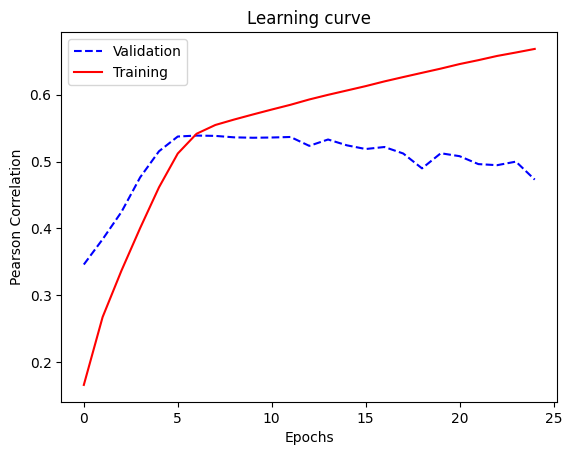

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(len(val_pcs)), val_pcs, '--b', label='Validation')
ax.plot(range(len(train_pcs)), train_pcs, '-r', label='Training')
leg = ax.legend()
plt.title("Learning curve")
plt.xlabel('Epochs')
plt.ylabel('Pearson Correlation')

Text(0, 0.5, 'MSE Loss')

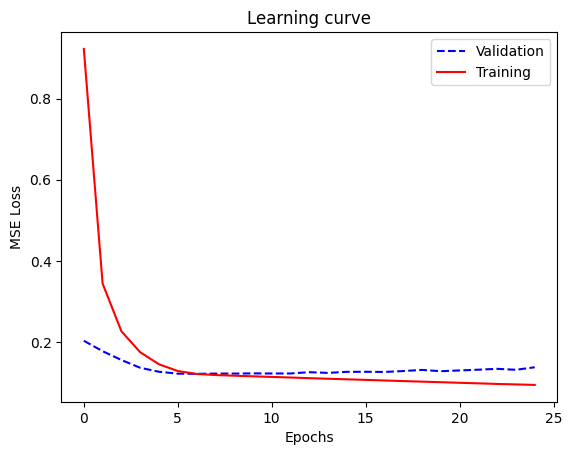

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(len(val_losses)), val_losses, '--b', label='Validation')
ax.plot(range(len(train_losses)), train_losses, '-r', label='Training')
leg = ax.legend()
plt.title("Learning curve")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

In [19]:
torch.save(brain_model.state_dict(), 'complete_brain_simple_nn.pth')